In [1]:
import os
import cv2
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torch.nn.functional import threshold, normalize
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm

## 1. Look through COD10K

In [2]:
for dirpath, dirnames, filenames in os.walk('/kaggle/input/cod10k'):
    #print(f"{dirpath}: contains {len(dirnames)} directories")
    if len(dirnames)==0:
        print(f"{dirpath} --> {len(filenames)} images")
    else:
        pass#print(f"{dirpath} --> {len(dirnames)} directories: {dirnames}")

/kaggle/input/cod10k/COD10K-v2/Test/Images/Image --> 4000 images
/kaggle/input/cod10k/COD10K-v2/Test/GT_Objects/GT_Object --> 4000 images
/kaggle/input/cod10k/COD10K-v2/Train/Images/Image --> 6000 images
/kaggle/input/cod10k/COD10K-v2/Train/GT_Objects/GT_Object --> 6000 images


## 2. Plot Sample Images

A sample image and it's corresponding ground truth mask are randomly picked from the Train directory of COD10K.

In [3]:
cod_path = Path("/kaggle/input/cod10k")
train_img_path = cod_path/"COD10K-v2/Train/Images/Image"
train_gt_path = cod_path/"COD10K-v2/Train/GT_Objects/GT_Object"
test_img_path = cod_path/"COD10K-v2/Test/Images/Image"
test_gt_path = cod_path/"COD10K-v2/Test/GT_Objects/GT_Object"

train_img_list = sorted(list(train_img_path.glob("*.jpg")))
train_gt_list = sorted(list(train_gt_path.glob("*.png")))
test_img_list = sorted(list(test_img_path.glob("*.jpg")))
test_gt_list = sorted(list(test_gt_path.glob("*.png")))

Random index = 611, Image size_HxW = (480, 640)


(-0.5, 639.5, 479.5, -0.5)

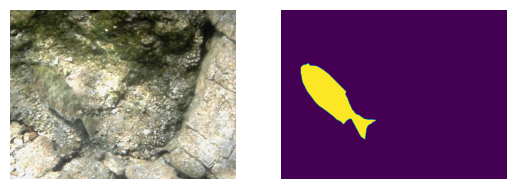

In [4]:
#random_idx = random.randint(0,len(train_img_list))
random_idx = 611
sample_img = train_img_list[random_idx]
sample_gt = train_gt_list[random_idx]
#sample_gt = train_gt_path/f"{sample_img.name[:len(sample_img.name)-3]}png"
(sample_img, sample_gt)

img = Image.open(sample_img)
gt = Image.open(sample_gt)

print(f"Random index = {random_idx}, Image size_HxW = {tuple(reversed(img.size))}")

plt.subplot(1,2,1)
plt.imshow(np.asarray(img))
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(np.asarray(gt))
plt.axis(False)

In [5]:
str(sample_gt)

'/kaggle/input/cod10k/COD10K-v2/Train/GT_Objects/GT_Object/COD10K-CAM-1-Aquatic-6-Fish-167.png'

## 3. Bounding Box

### 1. Find On A Sample Arry

In [6]:
a2 = np.array([[0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0],
               [0,0,0,1,1,1,0,0,0],
               [0,0,1,1,1,1,1,0,0],
               [0,0,0,1,0,1,0,0,0],
               [0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0]])
a2.shape

(8, 9)

In [7]:
# Finding top-left corner (x1, y1)
a2_0 = np.argmax(a2, axis=0)
a2_1 = np.argmax(a2, axis=1)

x1 = np.min(a2_0[np.nonzero(a2_0)])
y1 = np.min(a2_1[np.nonzero(a2_1)])

# Finding bottom-right corner (x2,y2)
x2,y2 = 0,0
H,W = a2.shape
for i in range(0,H):
    for j in range(0,W):
        if(a2[i][j]==1):
            if(i>x2): x2=i
            if(j>y2): y2=j

print(f"(x1, y1) = {x1,y1}")
print(f"(x2, y2) = {x2,y2}")

(x1, y1) = (3, 2)
(x2, y2) = (5, 6)


### 2. Find On Ground Truth Mask

In [8]:
gt_np = np.array(gt)
print(f"shape of gt_np = {gt_np.shape}")

# Finding top-left corner (x1, y1)
gt_np_0 = np.argmax(gt_np, axis=0)
gt_np_1 = np.argmax(gt_np, axis=1)

x1 = np.min(gt_np_0[np.nonzero(gt_np_0)])
y1 = np.min(gt_np_1[np.nonzero(gt_np_1)])

# Finding bottom-right corner (x2,y2)
x2,y2 = 0,0
H,W = gt_np.shape
for i in range(0,H):
    for j in range(0,W):
        if(gt_np[i][j]==255):
            if(i>x2): x2=i
            if(j>y2): y2=j

print(f"(x1, y1) = {x1,y1}")
print(f"(x2, y2) = {x2,y2}")

shape of gt_np = (480, 640)
(x1, y1) = (153, 56)
(x2, y2) = (367, 268)


**A RECTANGLE ON IMAGE**



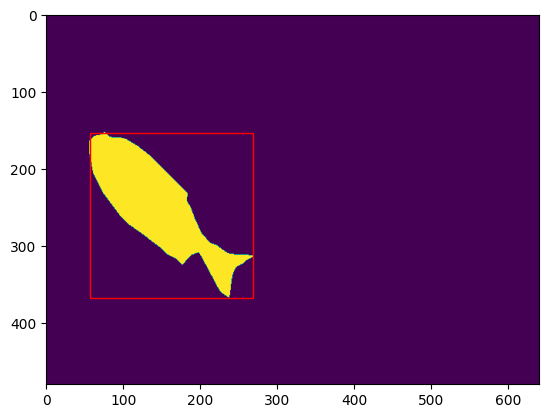

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

#im = Image.open('/kaggle/input/cod10k/COD10K-v2/Train/GT_Objects/GT_Object/COD10K-CAM-1-Aquatic-1-BatFish-3.png')
im = Image.open(str(sample_gt))


# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect = patches.Rectangle((y1,x1),y2-y1,x2-x1, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()